In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import pickle

from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from statsmodels.stats.stattools import jarque_bera

from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator

In [2]:
df = pd.read_csv('100_stocks_data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,Open,High,Low,Close,Volume,Ticker,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,40.433960,41.368938,40.204048,41.192673,7564701,ADANIENT.NS,5.275391e+06,7564701,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,40.464615,41.192673,38.824574,39.138786,17188171,ADANIENT.NS,-7.351532e+06,-9623470,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.986048,-5.114644,-4.986048
2,38.778587,39.246078,37.475750,38.065861,11525782,ADANIENT.NS,-1.119344e+07,-21149252,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.741336,-2.779612,-7.590699
3,37.996887,39.069813,37.506405,38.632977,10660990,ADANIENT.NS,-6.490088e+06,-10488262,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.489828,1.478839,-6.213960
4,38.832237,39.069813,36.939289,37.084900,11002957,ADANIENT.NS,-1.598905e+07,-21491219,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.007138,-4.089635,-9.972096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241460,1529.200000,1543.000000,1515.600000,1523.350000,551554,UNITDSPR.NS,-9.265698e+07,435915083,0.150406,8.972093e+06,...,2.228798,2.065220,0.163578,-10.052454,-6.487623,-3.564831,1472.924483,-0.382553,-0.383287,-41.590460
241461,1533.900000,1552.900000,1525.400000,1547.250000,516123,UNITDSPR.NS,-9.235293e+07,436431206,0.207457,9.452557e+06,...,2.339432,2.120062,0.219370,-12.031591,-7.596416,-4.435175,1479.501082,1.568911,1.556730,-40.674067
241462,1547.000000,1559.250000,1540.800000,1555.750000,1224149,UNITDSPR.NS,-9.159323e+07,437655355,0.234416,9.588658e+06,...,2.442367,2.184523,0.257843,-6.196572,-7.316447,1.119875,1488.679001,0.549362,0.547858,-40.348153
241463,1560.500000,1561.950000,1525.050000,1537.750000,320652,UNITDSPR.NS,-9.169316e+07,437334703,0.206728,7.394316e+06,...,2.398303,2.227279,0.171024,-10.747593,-8.002677,-2.744917,1490.797494,-1.156998,-1.163744,-41.038324


In [3]:
stock_tickers = df['Ticker'].unique().tolist()

In [4]:
with open('all_data__list_of_dataframes.pkl', 'rb') as f:
    all_data = pickle.load(f)

In [5]:
def fill_nan_values(df):
    # Group by 'Ticker' to handle each stock separately
    return df.groupby('Ticker').apply(lambda x: x.fillna(method='bfill').fillna(method='ffill'))

In [6]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'tr

<Axes: >

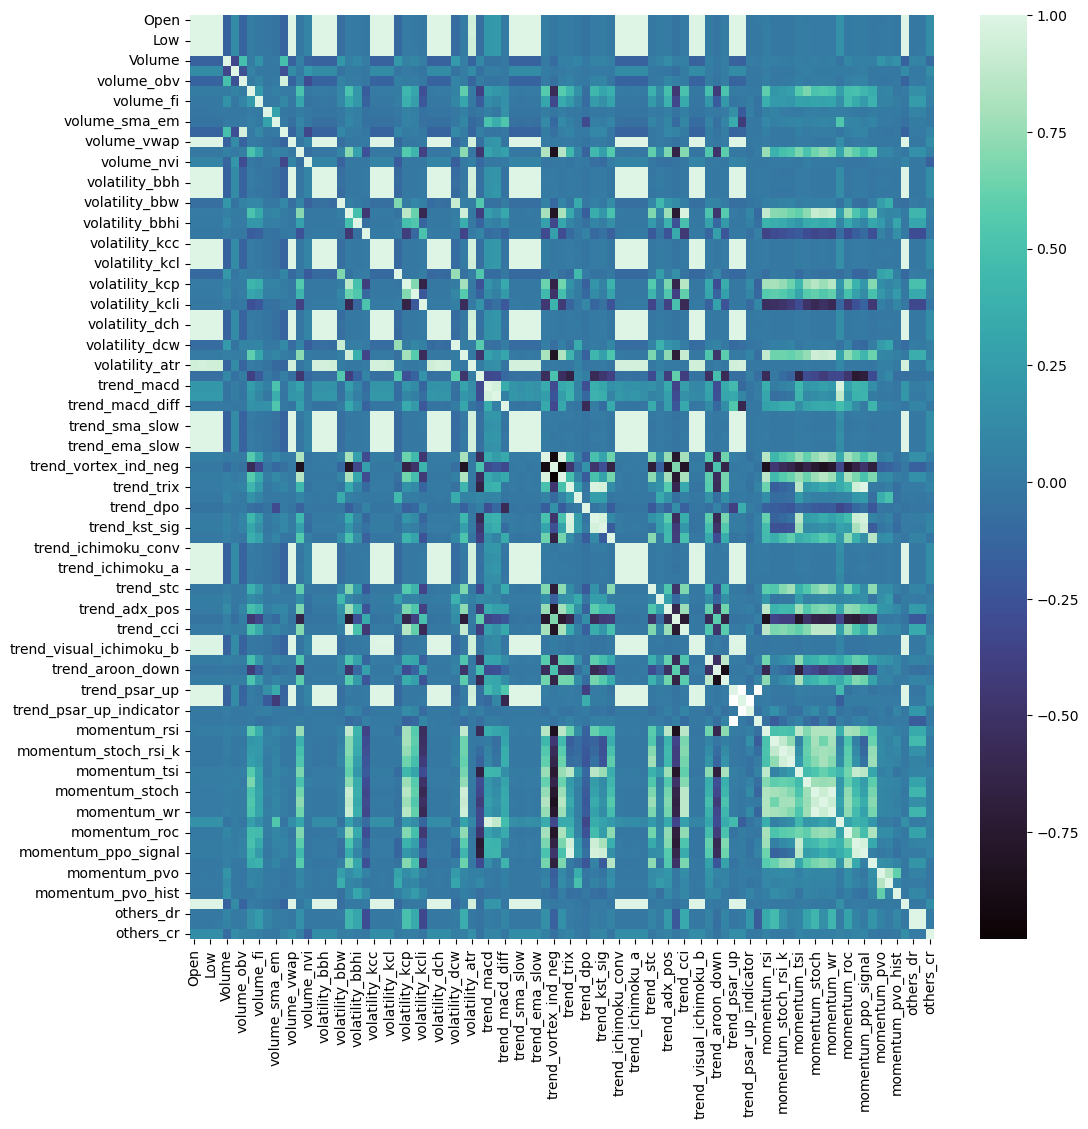

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), cmap='mako')

In [8]:
# def split_data(df, train_ratio=0.8):
#     # Sort the data by date
#     df = df.sort_values('Date')
    
#     # Find the split point
#     split_index = int(len(df) * train_ratio)
#     split_date = df.iloc[split_index]['Date']
    
#     # Split the data
#     train_data = df[df['Date'] <= split_date]
#     test_data = df[df['Date'] > split_date]
    
#     return train_data, test_data

# train_data, test_data = split_data(df)

In [9]:
def add_bb_rsi(df, bb_window=20, bb_std=2, rsi_window=14):
    # Calculate Bollinger Bands
    bb_indicator = BollingerBands(close=df['Close'], window=bb_window, window_dev=bb_std)
    df['bb_high'] = bb_indicator.bollinger_hband()
    df['bb_low'] = bb_indicator.bollinger_lband()
    df['bb_mid'] = bb_indicator.bollinger_mavg()
    
    # Calculate RSI
    rsi_indicator = RSIIndicator(close=df['Close'], window=rsi_window)
    df['rsi'] = rsi_indicator.rsi()
    
    return df

df = add_bb_rsi(df)
df

,Open,High,Low,Close,Volume,Ticker,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,bb_high,bb_low,bb_mid,rsi
0,40.433960,41.368938,40.204048,41.192673,7564701,ADANIENT.NS,5.275391e+06,7564701,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
1,40.464615,41.192673,38.824574,39.138786,17188171,ADANIENT.NS,-7.351532e+06,-9623470,NaN,NaN,...,NaN,NaN,NaN,-4.986048,-5.114644,-4.986048,NaN,NaN,NaN,NaN
2,38.778587,39.246078,37.475750,38.065861,11525782,ADANIENT.NS,-1.119344e+07,-21149252,NaN,NaN,...,NaN,NaN,NaN,-2.741336,-2.779612,-7.590699,NaN,NaN,NaN,NaN
3,37.996887,39.069813,37.506405,38.632977,10660990,ADANIENT.NS,-6.490088e+06,-10488262,NaN,NaN,...,NaN,NaN,NaN,1.489828,1.478839,-6.213960,NaN,NaN,NaN,NaN
4,38.832237,39.069813,36.939289,37.084900,11002957,ADANIENT.NS,-1.598905e+07,-21491219,NaN,NaN,...,NaN,NaN,NaN,-4.007138,-4.089635,-9.972096,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241460,1529.200000,1543.000000,1515.600000,1523.350000,551554,UNITDSPR.NS,-9.265698e+07,435915083,0.150406,8.972093e+06,...,-6.487623,-3.564831,1472.924483,-0.382553,-0.383287,-41.590460,1543.642918,1394.262082,1468.9525,65.824548
241461,1533.900000,1552.900000,1525.400000,1547.250000,516123,UNITDSPR.NS,-9.235293e+07,436431206,0.207457,9.452557e+06,...,-7.596416,-4.435175,1479.501082,1.568911,1.556730,-40.674067,1551.825815,1400.514185,1476.1700,69.475164
241462,1547.000000,1559.250000,1540.800000,1555.750000,1224149,UNITDSPR.NS,-9.159323e+07,437655355,0.234416,9.588658e+06,...,-7.316447,1.119875,1488.679001,0.549362,0.547858,-40.348153,1559.883151,1407.306849,1483.5950,70.674930
241463,1560.500000,1561.950000,1525.050000,1537.750000,320652,UNITDSPR.NS,-9.169316e+07,437334703,0.206728,7.394316e+06,...,-8.002677,-2.744917,1490.797494,-1.156998,-1.163744,-41.038324,1564.756483,1413.043517,1488.9000,64.861056


In [10]:
df = fill_nan_values(df)
df

,Open,High,Low,Close,Volume,Ticker,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,bb_high,bb_low,bb_mid,rsi
0,40.433960,41.368938,40.204048,41.192673,7564701,ADANIENT.NS,5.275391e+06,7564701,-0.057881,-5.026581e+06,...,6.681622,-3.588219,37.437431,-4.986048,-5.114644,0.000000,40.135806,35.490873,37.81334,42.562476
1,40.464615,41.192673,38.824574,39.138786,17188171,ADANIENT.NS,-7.351532e+06,-9623470,-0.057881,-5.026581e+06,...,6.681622,-3.588219,37.437431,-4.986048,-5.114644,-4.986048,40.135806,35.490873,37.81334,42.562476
2,38.778587,39.246078,37.475750,38.065861,11525782,ADANIENT.NS,-1.119344e+07,-21149252,-0.057881,-5.026581e+06,...,6.681622,-3.588219,37.437431,-2.741336,-2.779612,-7.590699,40.135806,35.490873,37.81334,42.562476
3,37.996887,39.069813,37.506405,38.632977,10660990,ADANIENT.NS,-6.490088e+06,-10488262,-0.057881,-5.026581e+06,...,6.681622,-3.588219,37.437431,1.489828,1.478839,-6.213960,40.135806,35.490873,37.81334,42.562476
4,38.832237,39.069813,36.939289,37.084900,11002957,ADANIENT.NS,-1.598905e+07,-21491219,-0.057881,-5.026581e+06,...,6.681622,-3.588219,37.437431,-4.007138,-4.089635,-9.972096,40.135806,35.490873,37.81334,42.562476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241460,1529.200000,1543.000000,1515.600000,1523.350000,551554,UNITDSPR.NS,-9.265698e+07,435915083,0.150406,8.972093e+06,...,-6.487623,-3.564831,1472.924483,-0.382553,-0.383287,-41.590460,1543.642918,1394.262082,1468.95250,65.824548
241461,1533.900000,1552.900000,1525.400000,1547.250000,516123,UNITDSPR.NS,-9.235293e+07,436431206,0.207457,9.452557e+06,...,-7.596416,-4.435175,1479.501082,1.568911,1.556730,-40.674067,1551.825815,1400.514185,1476.17000,69.475164
241462,1547.000000,1559.250000,1540.800000,1555.750000,1224149,UNITDSPR.NS,-9.159323e+07,437655355,0.234416,9.588658e+06,...,-7.316447,1.119875,1488.679001,0.549362,0.547858,-40.348153,1559.883151,1407.306849,1483.59500,70.674930
241463,1560.500000,1561.950000,1525.050000,1537.750000,320652,UNITDSPR.NS,-9.169316e+07,437334703,0.206728,7.394316e+06,...,-8.002677,-2.744917,1490.797494,-1.156998,-1.163744,-41.038324,1564.756483,1413.043517,1488.90000,64.861056


In [11]:
def calculate_true_range(df):
    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(abs(df['High'] - df['Close'].shift(1)),
                                     abs(df['Low'] - df['Close'].shift(1))))
    return df

def coiled_spring_nr7(df):
    df['ATR'] = df['TR'].rolling(window=7).mean()
    df['NR7'] = df['TR'].rolling(window=7).min() == df['TR']
    
    df['long_signal'] = (df['NR7'] & (df['Close'] > df['bb_mid']) & (df['rsi'] < 50))
    df['short_signal'] = (df['NR7'] & (df['Close'] < df['bb_mid']) & (df['rsi'] > 50))
    
    return df

def finger_finder(df, atr_period=14, atr_multiplier=2):
    df['ATR'] = df['TR'].rolling(window=atr_period).mean()
    df['Upper_Band'] = df['High'].rolling(window=2).max() + (df['ATR'] * atr_multiplier)
    df['Lower_Band'] = df['Low'].rolling(window=2).min() - (df['ATR'] * atr_multiplier)
    
    df['long_signal'] = (df['Close'] > df['Upper_Band'].shift(1)) & (df['rsi'] < 70)
    df['short_signal'] = (df['Close'] < df['Lower_Band'].shift(1)) & (df['rsi'] > 30)
    
    return df

def power_spike(df, volume_threshold=2):
    df['volume_ma'] = df['Volume'].rolling(window=20).mean()
    df['price_change'] = df['Close'] - df['Open']
    
    df['long_signal'] = (df['Volume'] > df['volume_ma'] * volume_threshold) & (df['price_change'] > 0) & (df['rsi'] < 70)
    df['short_signal'] = (df['Volume'] > df['volume_ma'] * volume_threshold) & (df['price_change'] < 0) & (df['rsi'] > 30)
    
    return df


In [12]:
def backtest_strategy(df, initial_capital=100000, transaction_cost_pct=0.001, risk_reward_ratio=2, trailing_stop_pct=0.05):
    df['position'] = np.where(df['long_signal'], 1, np.where(df['short_signal'], -1, 0))
    df['position'] = df['position'].fillna(method='ffill')
    
    df['entry_price'] = np.nan
    df['stop_loss'] = np.nan
    df['take_profit'] = np.nan
    df['trailing_stop'] = np.nan
    
    position = 0
    entry_price = 0
    stop_loss = 0
    take_profit = 0
    trailing_stop = 0
    
    for i in range(1, len(df)):
        if df['position'].iloc[i] != 0 and position == 0:
            position = df['position'].iloc[i]
            entry_price = df['Close'].iloc[i]
            stop_loss = entry_price * (1 - position * trailing_stop_pct)
            take_profit = entry_price * (1 + position * trailing_stop_pct * risk_reward_ratio)
            trailing_stop = stop_loss if position == 1 else take_profit
        
        elif position != 0:
            if position == 1:
                trailing_stop = max(trailing_stop, df['Close'].iloc[i] * (1 - trailing_stop_pct))
            else:
                trailing_stop = min(trailing_stop, df['Close'].iloc[i] * (1 + trailing_stop_pct))
            
            if (position == 1 and df['Low'].iloc[i] <= trailing_stop) or \
               (position == -1 and df['High'].iloc[i] >= trailing_stop) or \
               df['position'].iloc[i] == -position:
                position = 0
                entry_price = 0
                stop_loss = 0
                take_profit = 0
                trailing_stop = 0
        
        df['entry_price'].iloc[i] = entry_price
        df['stop_loss'].iloc[i] = stop_loss
        df['take_profit'].iloc[i] = take_profit
        df['trailing_stop'].iloc[i] = trailing_stop
    
    df['returns'] = df['Close'].pct_change()
    df['strategy_returns'] = df['position'].shift(1) * df['returns'] - abs(df['position'].diff()) * transaction_cost_pct
    
    df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()
    df['cumulative_strategy'] = initial_capital * df['cumulative_returns']
    
    total_return = df['cumulative_returns'].iloc[-1] - 1
    sharpe_ratio = np.sqrt(252) * df['strategy_returns'].mean() / df['strategy_returns'].std()
    max_drawdown = (df['cumulative_strategy'] / df['cumulative_strategy'].cummax() - 1).min()
    
    return {
        'Total Return': total_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Final Portfolio Value': df['cumulative_strategy'].iloc[-1]
    }

def process_stock(df, strategy_func):
    df = add_bb_rsi(df)
    df = calculate_true_range(df)
    df = fill_nan_values(df)
    df = strategy_func(df)
    results = backtest_strategy(df) 
    return results

strategies = {
    'Coiled Spring NR7': coiled_spring_nr7,
    'Finger Finder': finger_finder,
    'Power Spike': power_spike
}

In [13]:
results = {}

for strategy_name, strategy_func in strategies.items():
    strategy_results = {}
    for df in all_data:
        ticker = df['Ticker'].iloc[0]  # Extract the ticker from the DataFrame
        stock_results = process_stock(df, strategy_func)
        strategy_results[ticker] = stock_results
    results[strategy_name] = strategy_results

# Print or analyze results
for strategy, stocks in results.items():
    print(f"\nResults for {strategy}:")
    for ticker, performance in stocks.items():
        print(f"{ticker}: {performance}")

# Optional: Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame({(strategy, ticker): performance 
                           for strategy, stocks in results.items() 
                           for ticker, performance in stocks.items()})
print("\nResults DataFrame:")
print(results_df)


Results for Coiled Spring NR7:
ADANIENT.NS: {'Total Return': -0.10371573181926941, 'Sharpe Ratio': -0.18650802152202975, 'Max Drawdown': -0.17742283911519252, 'Final Portfolio Value': 89628.42681807306}
ADANIPORTS.NS: {'Total Return': -0.13861850205264448, 'Sharpe Ratio': -0.2909044792510182, 'Max Drawdown': -0.176235689888685, 'Final Portfolio Value': 86138.14979473555}
APOLLOHOSP.NS: {'Total Return': -0.08499160823852348, 'Sharpe Ratio': -0.22941084847125812, 'Max Drawdown': -0.10865264506338257, 'Final Portfolio Value': 91500.83917614765}
ASIANPAINT.NS: {'Total Return': -0.15399972059232414, 'Sharpe Ratio': -0.43489992158269913, 'Max Drawdown': -0.17514540954775704, 'Final Portfolio Value': 84600.02794076758}
AXISBANK.NS: {'Total Return': -0.2706899671329335, 'Sharpe Ratio': -0.7641583228920122, 'Max Drawdown': -0.2975883467525774, 'Final Portfolio Value': 72931.00328670665}
BAJAJ-AUTO.NS: {'Total Return': 0.011677862283091534, 'Sharpe Ratio': 0.059397448923369935, 'Max Drawdown': 

In [14]:
results_df.columns

MultiIndex([('Coiled Spring NR7',   'ADANIENT.NS'),
            ('Coiled Spring NR7', 'ADANIPORTS.NS'),
            ('Coiled Spring NR7', 'APOLLOHOSP.NS'),
            ('Coiled Spring NR7', 'ASIANPAINT.NS'),
            ('Coiled Spring NR7',   'AXISBANK.NS'),
            ('Coiled Spring NR7', 'BAJAJ-AUTO.NS'),
            ('Coiled Spring NR7', 'BAJFINANCE.NS'),
            ('Coiled Spring NR7', 'BAJAJFINSV.NS'),
            ('Coiled Spring NR7',       'BPCL.NS'),
            ('Coiled Spring NR7', 'BHARTIARTL.NS'),
            ...
            (      'Power Spike',        'SRF.NS'),
            (      'Power Spike',  'TATAPOWER.NS'),
            (      'Power Spike', 'TORNTPHARM.NS'),
            (      'Power Spike',      'TRENT.NS'),
            (      'Power Spike',   'TVSMOTOR.NS'),
            (      'Power Spike',        'VBL.NS'),
            (      'Power Spike',       'VEDL.NS'),
            (      'Power Spike',     'ZOMATO.NS'),
            (      'Power Spike',  'ZYDUSLIFE.NS

In [15]:
coiled_spring_nr7_results_df = pd.DataFrame(results_df['Coiled Spring NR7'])
coiled_spring_nr7_results_df.to_csv('coiled_spring_nr7_results_df_v2.csv')

finger_finder_results_df = pd.DataFrame(results_df['Finger Finder'])
finger_finder_results_df.to_csv('finger_finder_results_df_v2.csv')

power_spike_results_df = pd.DataFrame(results_df['Power Spike'])
power_spike_results_df.to_csv('power_spike_results_df_v2.csv')